In [1]:
# 结构信息

In [1]:
import torch
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import time
from networkx.algorithms.bipartite.basic import color
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #显示负号

In [3]:
# 得到P
acc=pd.read_csv("../data/地震加速度.csv")  # m/s^2
acc=acc.iloc[171,1:].values
ag=acc
n = ag.shape[0]
dt=0.02

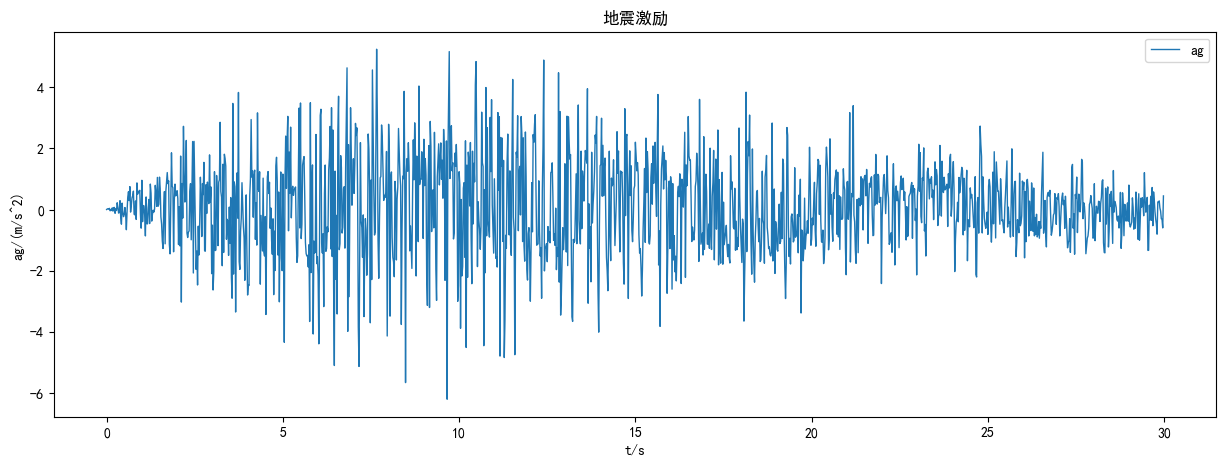

In [4]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,30,0.02),ag, label='ag', linewidth=1)
plt.ylabel("ag/(m/s^2)")
plt.xlabel("t/s")
plt.legend(loc='best')
plt.title("地震激励")
plt.show()

In [5]:
m = torch.tensor([5000.0, 5000.0, 5000.0, 5000.0, 5000.0])   ##单位：kg
M = torch.diag(m)

In [6]:
#定义初始刚度，单位：N/m
k = torch.tensor([1e7, 1e7, 1e7, 1e7, 1e7]) 
K = torch.tensor([[k[0]+k[1],-k[1],0,0,0],
                [-k[1],k[1]+k[2],-k[2],0,0],
                [0,-k[2],k[2]+k[3],-k[3],0],
                [0,0,-k[2],k[3]+k[4],-k[4]],
                [0,0,0,-k[4],k[4]]])

In [7]:
zeta = 0.02; w1 = 0.4479; w2 = 1.16   #定义结构阻尼比，1、2阶频率 9层
a_coe = 2*w1*w2*zeta/(w1+w2); b_coe = 2*zeta/(w1+w2)
C =a_coe*M + b_coe*K  #计算瑞利阻尼

In [8]:
dofs = M.shape[0]   #自由度个数

In [9]:
#定义、计算积分常数
beta = 0.25
gama = 0.5
a0 = (1 / beta / dt / dt)
a1 = (gama / beta / dt)
a2 = (1 / beta / dt)
a3 = (1 / 2 / beta - 1)
a4 = (gama / beta - 1)
a5 = (dt / 2 * (gama / beta - 2))
a6 = (dt * (1 - gama))
a7 = (dt * gama)

In [10]:
#形成等效刚度矩阵,建立结构运动状态0矩阵
n=len(ag)
u = torch.zeros((dofs, n))   
v = torch.zeros((dofs, n))
acc = torch.zeros((dofs, n))
du = torch.zeros((dofs, n))   #定义位移增量
u_re=torch.zeros((dofs, n))
Fre=torch.zeros((dofs, n))
k_t=k

In [ ]:
#增量方程形式逐步积分
timestamp1=time.time()
for i in range(1, n):
    KK = torch.tensor([
                    [k_t[0]+k_t[1],-k_t[1],0,0,0],
                    [-k_t[1],k_t[1]+k_t[2],-k_t[2],0,0],
                    [0,-k_t[2],k_t[2]+k[3],-k_t[3],0],
                    [0,0,-k_t[2],k_t[3]+k_t[4],-k_t[4]],
                    [0,0,0,-k_t[4],k_t[4]]
                  ])
    dPP = -(ag[i] - ag[i - 1]) * m + M@(a2 * v[:, i - 1] + (a3 + 1) * acc[:, i - 1]) + C@((a4 + 1) * v[:, i - 1] + a5 * acc[:, i - 1])
    K_hat = KK + a0 * M + a1 * C          #形成相对刚度矩阵
    K_hat_inv = torch.linalg.inv(K_hat)
    du[:, i] = K_hat_inv@dPP     #相对刚度矩阵的逆与 外力变化值点乘  得到 位移变化值
    u[:, i] = u[:, i - 1] + du[:, i]      #得到本时间步结束时的总位移
    acc[:, i] = a0 * du[:, i] - a2 * v[:, i - 1] - a3 * acc[:, i - 1]       #计算加速度
    v[:, i] = a1 * du[:, i] - a4 * v[:, i - 1] - a5 * acc[:, i - 1]         #计算速度

    iter_count = 0
    while torch.linalg.norm(du[:, i])>1e-5 and iter_count<500:
        dPP = -(ag[i] - ag[i - 1]) * m + M@(a2 * v[:, i - 1] + (a3 + 1) * acc[:, i - 1]) + C@((a4 + 1) * v[:, i - 1] + a5 * acc[:, i - 1])
        K_hat = KK + a0 * M + a1 * C          
        K_hat_inv = torch.linalg.inv(K_hat)
        du[:, i] = K_hat_inv@dPP     
        u[:, i] = u[:, i - 1] + du[:, i]     
        acc[:, i] = a0 * du[:, i] - a2 * v[:, i - 1] - a3 * acc[:, i - 1]     
        v[:, i] = a1 * du[:, i] - a4 * v[:, i - 1] - a5 * acc[:, i - 1]
        iter_count +=1
    
    u_re[0,i]=u[0,i]
    u_re[1:,i]=u[1:,i]-u[0:4,i]
    k_t=k+1000*k*u_re[:,i]**2

timestamp2=time.time()
time_difference = timestamp2 - timestamp1
print("时间差（秒）：", time_difference)

In [ ]:
pd.DataFrame(u.numpy()).to_csv("Newmark_beta_u_result.csv")

In [ ]:
u.shape

In [ ]:
K_re=torch.tensor([
    [-k[0],k[1],0,0,0],
    [0,-k[1],k[2],0,0],
    [0,0,-k[2],k[3],0],
    [0,0,0,-k[3],k[4]],
    [0,0,0,0,-k[4]]])

In [ ]:
k.unsqueeze(1).shape

In [ ]:
F_re=K_re@(k.unsqueeze(1)*u_re+1000*(k.unsqueeze(1))*u_re**3)
F_re_nl=K_re@(1000*u_re**3)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),u[0,:])

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(1500),F_re_nl[0,:])